In [1]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

from cuml.ensemble import RandomForestRegressor as cuRF
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split

import os
os.chdir("/local-scratch/GlucoseProject/mobicom23_mobispectral/regression")
import sys
sys.path.append(os.getcwd())
from utils import prepare_data, evaluate_image, evaluate_image_SEG, ard_image

In [2]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'
step = 1

In [3]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
# X_train, X_val, y_train, y_val = TTS(X_train, y_train, test_size=0.3, random_state=42)

Loading hyper dataset
Loading hyper dataset


In [4]:
# scaler = MinMaxScaler()
x_scaler = RobustScaler()
y_scaler = RobustScaler()
# scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = x_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
t = np.arange(len(X_test))
plt.plot(t, y_test, 'r', linewidth=2, label='Label')

In [ ]:
plt.plot(t, y_pred, 'g', linewidth=2, label='Predicted')

In [ ]:
# param_grid = {"n_estimators":[5,10,50,100,200,500],"max_depth":[5,10,50,100,200,500]}
param_grid = {"n_estimators":[5,50,100],"max_depth":[8,9,10]}

In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(),param_grid,cv = 3)
grid_search.fit(X_train, y_train)

In [ ]:
y_pred=grid_search.predict(X_test)
print(y_pred)

In [ ]:
plt.figure(figsize=(15, 10))
t = np.arange(len(X_test))
# y_test curve
plt.plot(t, y_test, 'r', linewidth=2, label='Label')
# y_pred curve
plt.plot(t, y_pred, 'g', linewidth=2, label='Predicted')
plt.legend()
plt.show()

10
30
50
70
90


Best n_estimators and r2 score:  inf inf
90 0.6381692527923717


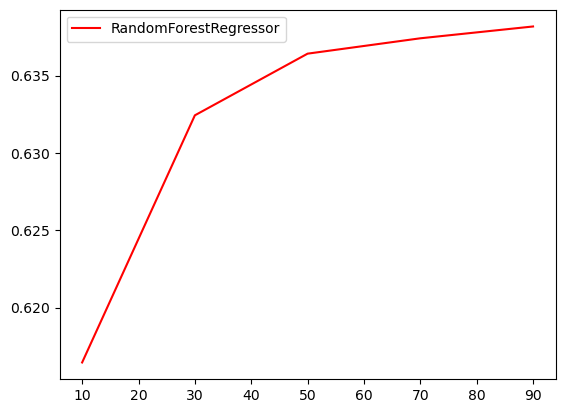

In [8]:
axisx = range(10,100,20)
rs = []
# Print the best n_estimators
best_i = np.inf
best_r2_score = np.inf
for i in axisx:
    print(i)
    model = cuRF(n_estimators=i,random_state=42)
    # rs.append(CVS(model,X_train,y_train,cv=cv,n_jobs=-1).mean())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    val_r2_score = r2_score(y_test, y_pred)
    rs.append(val_r2_score.mean())
    if val_r2_score.mean() > best_r2_score:
        best_r2_score = val_r2_score.mean()
        best_i = i

print("Best n_estimators and r2 score: ", best_i, best_r2_score)

print(axisx[rs.index(max(rs))],max(rs))
# plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForestRegressor")
plt.legend()
plt.show()

In [ ]:
ard = ard_image(test_data, model, scaler_X=x_scaler, scaler_y=y_scaler)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())
evaluate_image(test_data, model=model, scaler_X=x_scaler, scaler_y=y_scaler)
evaluate_image_SEG(test_data, model=model, scaler_X=x_scaler, scaler_y=y_scaler)

In [ ]:
# max_depth learning curve
superpa = []
for i in range(10,30,1):
    model = cuRF(n_estimators=170
                                 ,max_depth=i
                                 ,random_state=42
                                 )
    model_s = cross_val_score(model
                            ,X_train
                            ,y_train
                            ,cv=10
                            #,scoring='roc_auc'
                           ).mean()# 评估指标
    superpa.append(model_s)
print(max(superpa),superpa.index(max(superpa)),(superpa.index(max(superpa)))*2+10)#输出最大值及其索引
 
plt.figure(figsize=[20,5])
plt.plot(range(10,30,2),superpa)#横纵坐标

plt.show()

In [ ]:
# min_samples_split的学习曲线，分割内部节点所需的最小样本数
superpa = []
for i in range(2,10,2):
    model = RandomForestRegressor(n_estimators=170
                                 ,max_depth=12
                                 ,min_samples_split=i
                                 ,random_state=42
                                 ,n_jobs=-1)
    model_s = cross_val_score(model
                            ,X_train
                            ,y_train
                            ,cv=10
                            #,scoring='roc_auc'
                           ).mean()# 评估指标
    superpa.append(model_s)
print(max(superpa),superpa.index(max(superpa)),(superpa.index(max(superpa)))*2+2)#输出最大值及其索引
 
plt.figure(figsize=[20,5])
plt.plot(range(2,10,2),superpa)#横纵坐标
plt.show()

In [ ]:
# min_samples_leaf的学习曲线
superpa = []
for i in range(1,15,1):
    model = RandomForestRegressor(n_estimators=170
                                 ,max_depth=12
                                 ,min_samples_split=2
                                 ,min_samples_leaf=i
                                 ,random_state=42
                                 )
    model_s = cross_val_score(model
                            ,X_train
                            ,y_train
                            ,cv=10
                            #,scoring='roc_auc'
                           ).mean()# 评估指标
    superpa.append(model_s)
print(max(superpa),superpa.index(max(superpa)),(superpa.index(max(superpa)))*1+1)#输出最大值及其索引
 
plt.figure(figsize=[20,5])
plt.plot(range(1,15,1),superpa)#横纵坐标
plt.show()

In [ ]:
# max_features的学习曲线，每棵树用到的最大特征数
#from sklearn.model_selection import GridSearchCV
 
param_grid = {'max_features':np.arange(3, 11, 1)} 
 
model = RandomForestRegressor(n_estimators=170
                                 ,max_depth=12
                                 ,min_samples_split=2
                                 ,min_samples_leaf=1
                                 ,random_state=42
                                 )
GS = GridSearchCV(model,param_grid,cv=10)
GS.fit(X_train, y_train)
 
print(GS.best_params_)
#print(GS.best_score_)

In [ ]:
 
# param_grid = {'max_features':np.arange(3, 11, 1)} 
 
# model = RandomForestRegressor(n_estimators=170
#                                  ,max_depth=12
#                                  ,min_samples_split=2
#                                  ,min_samples_leaf=1
#                                  ,random_state=42
#                                  )
# GS = GridSearchCV(model,param_grid,cv=10)
# GS.fit(X_train, y_train)
 
# print(GS.best_params_)
# #print(GS.best_score_)

In [ ]:
# model = RandomForestRegressor(n_estimators=170
#                                  ,max_depth=12
#                                  ,min_samples_split=2
#                                  ,min_samples_leaf=1
#                                  ,random_state=42
#                                  )
# model.fit(X_train, y_train) 
# # 返回拟合优度the coefficient of determination
# model.score(X_test,y_test)

In [ ]:
# metrics.mean_squared_error(y_test, y_pred)
# 24.275331856914285

# model.set_params()
# RandomForestRegressor(max_depth=12, n_estimators=170, random_state=42)

# model.feature_importances_


# plt.figure(figsize=(15, 10))
# t = np.arange(len(X_test))
# plt.plot(t, y_test, 'r', linewidth=2, label='label')
# plt.plot(t, y_pred, 'g', linewidth=2, label='predicted')
# plt.legend()
# plt.show()